In [1]:
# !pip install prophet statsmodels

In [2]:
# !pip install pandas gspread google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

In [3]:
!pip install lightgbm

#### Importing Libraries

In [4]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#### Loading Data

In [5]:
import os
os.getcwd()

'C:\\Users\\Hannah\\Desktop\\DS_Y3S1\\DSCP\\Asg2\\Final Submissions'

In [6]:
import os
import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

def create_gspread_client(credentials_path):
    scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
    creds = Credentials.from_service_account_file(credentials_path, scopes=scope)
    # Authorize the gspread client
    client = gspread.authorize(creds)
    return client

def authenticate_drive(credentials_path):
    scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
    # Load the credentials
    creds = Credentials.from_service_account_file(credentials_path, scopes=scope)
    # Build the Google Drive service
    drive_service = build('drive', 'v3', credentials=creds)
    return drive_service

def get_sheets_in_folder(drive_service, folder_id):
    query = f"'{folder_id}' in parents and mimeType='application/vnd.google-apps.spreadsheet'"
    results = drive_service.files().list(q=query, pageSize=1000, fields="files(id, name)").execute()
    items = results.get('files', [])
    print(items)
    return items

def read_and_concat_sheets(client, file_id, header_row=1):
    spreadsheet = client.open_by_key(file_id)
    all_sheets_data = []
    for sheet in spreadsheet.worksheets():
        sheet_data = pd.DataFrame(sheet.get_all_values())
        # Check if the first row has empty values
        if any(pd.isna(sheet_data.iloc[header_row-1])):
            # If the header row has empty values, use the next row as the header
            sheet_data.columns = sheet_data.iloc[header_row]
        else:
            # If the header row is not empty, use the header row as the header
            sheet_data.columns = sheet_data.iloc[header_row-1]
        sheet_data.reset_index(drop=True, inplace=True)  # Reset index
        # Define the schema of the final merged table
        final_columns = ['Timestamp', 'Number of Worms (non-counted)', 'Phosphorous01', 'Phosphorous02',
                         'Nitrogen01', 'Nitrogen02', 'Potassium01', 'Potassium02', 'Light Intensity',
                         'Temp01', 'Hum01', 'Heat01', 'SoilM01', 'SoilM02', 'Buzzer', 'pH Rod 1', 'pH Rod 2']
        # Drop any extra columns from the individual table
                # Drop any duplicate columns
        sheet_data = sheet_data.loc[:, ~sheet_data.columns.duplicated()]
        sheet_data = sheet_data.reindex(columns=final_columns, fill_value=None)
        print(sheet_data.shape)
        sheet_name = sheet.title
        print("Sheet Name:", sheet_name)
        all_sheets_data.append(sheet_data)
    # Concatenate all sheet data into a single DataFrame
    concatenated_data = pd.concat(all_sheets_data, ignore_index=True)
    return concatenated_data

def load_and_concat_all_sheets_in_centers(base_directory_id, credentials_path):
    try:
        client = create_gspread_client(credentials_path)
        drive_service = authenticate_drive(credentials_path)
        
        compost = []
        
        center_folders = drive_service.files().list(q=f"'{base_directory_id}' in parents and mimeType='application/vnd.google-apps.folder'",
                                                    fields="files(id, name)").execute().get('files', [])
        
        for center_folder in center_folders:
            sheet_files = get_sheets_in_folder(drive_service, center_folder['id'])
            for sheet_file in sheet_files:
                sheet_data = read_and_concat_sheets(client, sheet_file['id'], header_row=1)
                sheet_data['Location'] = center_folder['name'].split('_')[1]
                compost.append(sheet_data)
        
        return pd.concat(compost, ignore_index=True)
    except HttpError as error:
        print(f"An error occurred: {error}")
        return None

# Example usage
base_directory_id = '1uH8e33HJQG4v8BmCZ_EJYmGH-VmWI547'  # The ID of the main folder containing center folders
credentials_path = r'C:\Users\Hannah\Desktop\DS_Y3S1\DSCP\Asg2\streamlit_npkcomposter_anomaly\streamlit-npkcomposter-anomaly-71e49f3f60a9.json' # Path to your service account credentials file
all_data = load_and_concat_all_sheets_in_centers(base_directory_id, credentials_path)
print(all_data.shape)

[{'id': '1fhf6gdJ3Fy0Lorazknh8IXiGFxLJI9b8RRjRnOcbWHs', 'name': 'Sengkang_Rack (Jan - Jun 2024)'}]
(20, 17)
Sheet Name: 2 Apr 2024
(20, 17)
Sheet Name: 9 Apr 2024
(21, 17)
Sheet Name: 16 Apr 2024
(21, 17)
Sheet Name: 23 Apr 2024
(21, 17)
Sheet Name: 30 Apr 2024
(22, 17)
Sheet Name: 3 May 2024
(26, 17)
Sheet Name: 5 May 2024
(22, 17)
Sheet Name: 6 May 2024
(22, 17)
Sheet Name: 11 May 2024
(22, 17)
Sheet Name: 14 May 2024
(22, 17)
Sheet Name: 19 May 2024
(29, 17)
Sheet Name: 21 May 2024
(24, 17)
Sheet Name: 23 May 2024
[]
[]
[]
[]
[]
[]
[]
[]
[{'id': '1z873cO3CtP4_3uOwwZndfZzfv3JR3jnlafoguT5Fa30', 'name': '01 MacPherson_Rack (22 Dec 2023 to 18 Apr 2024)'}, {'id': '1_xMxiCynn_lMKSOghh0Ac757ORldPCNUJyaoRudX1nI', 'name': '02 MacPherson_Rack (01 May 2024 to 06 Jun 2024)'}]
(810, 17)
Sheet Name: 22 December 2023
(810, 17)
Sheet Name:  23 December 2023
(801, 17)
Sheet Name: 30 December 2023
(819, 17)
Sheet Name: 5 April 2024
(1000, 17)
Sheet Name: 6 April 2024
(842, 17)
Sheet Name: 7 April 202

In [7]:
pd.set_option('display.max_column', None)
all_data.head()

,Timestamp,Number of Worms (non-counted),Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Light Intensity,Temp01,Hum01,Heat01,SoilM01,SoilM02,Buzzer,pH Rod 1,pH Rod 2,Location
0,Timestamp,NaN,Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Light Intensity,Temp01,Hum01,Heat01,SoilM01,SoilM02,NaN,NaN,NaN,SengKang
1,"2 Apr 2024, 3:30 PM",NaN,0,,0,,0,,43,28.9,76,51,0,,NaN,NaN,NaN,SengKang
2,"2 Apr 2024, 3:40 PM",NaN,0,,0,,0,,43,28.9,77,52,0,,NaN,NaN,NaN,SengKang
3,"2 Apr 2024, 3:50 PM",NaN,0,,0,,0,,43,28.7,76,52,0,,NaN,NaN,NaN,SengKang
4,"2 Apr 2024, 4:00 PM",NaN,0,,0,,0,,44,28.9,77,52,0,,NaN,NaN,NaN,SengKang


In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6756 entries, 0 to 6755
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Timestamp                      5914 non-null   object
 1   Number of Worms (non-counted)  5622 non-null   object
 2   Phosphorous01                  5914 non-null   object
 3   Phosphorous02                  5914 non-null   object
 4   Nitrogen01                     5914 non-null   object
 5   Nitrogen02                     5914 non-null   object
 6   Potassium01                    5914 non-null   object
 7   Potassium02                    5914 non-null   object
 8   Light Intensity                5914 non-null   object
 9   Temp01                         5914 non-null   object
 10  Hum01                          5914 non-null   object
 11  Heat01                         5914 non-null   object
 12  SoilM01                        5914 non-null   object
 13  Soi

#### Missing Rows Handling

In [9]:
# Create a copy of the original DataFrame
filtered_data = all_data.copy()

# Calculate the threshold for dropping columns
threshold = len(filtered_data) * 0.5

# Iterate over each column
for column in filtered_data.columns:
    # Calculate the percentage of NaN values in the column
    nan_percentage = filtered_data[column].isna().mean()
    
    # If NaN percentage >= 50%, drop the column
    if nan_percentage >= 0.5:
        filtered_data.drop(column, axis=1, inplace=True)

# Print the updated DataFrame shape
print("Shape after dropping columns with NaN or null values >= 50%:", filtered_data.shape)


Shape after dropping columns with NaN or null values >= 50%: (6756, 15)


In [10]:
filtered_data.head()

,Timestamp,Number of Worms (non-counted),Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Light Intensity,Temp01,Hum01,Heat01,SoilM01,SoilM02,Location
0,Timestamp,NaN,Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Light Intensity,Temp01,Hum01,Heat01,SoilM01,SoilM02,SengKang
1,"2 Apr 2024, 3:30 PM",NaN,0,,0,,0,,43,28.9,76,51,0,,SengKang
2,"2 Apr 2024, 3:40 PM",NaN,0,,0,,0,,43,28.9,77,52,0,,SengKang
3,"2 Apr 2024, 3:50 PM",NaN,0,,0,,0,,43,28.7,76,52,0,,SengKang
4,"2 Apr 2024, 4:00 PM",NaN,0,,0,,0,,44,28.9,77,52,0,,SengKang


In [11]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6756 entries, 0 to 6755
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Timestamp                      5914 non-null   object
 1   Number of Worms (non-counted)  5622 non-null   object
 2   Phosphorous01                  5914 non-null   object
 3   Phosphorous02                  5914 non-null   object
 4   Nitrogen01                     5914 non-null   object
 5   Nitrogen02                     5914 non-null   object
 6   Potassium01                    5914 non-null   object
 7   Potassium02                    5914 non-null   object
 8   Light Intensity                5914 non-null   object
 9   Temp01                         5914 non-null   object
 10  Hum01                          5914 non-null   object
 11  Heat01                         5914 non-null   object
 12  SoilM01                        5914 non-null   object
 13  Soi

1. Calculate the NPK Ratio using the ideal 4:2:1 ratio as a reference.
2. Anomaly Detection using Prophet.
3. Time Series Analysis for NPK Ratio Trends.
4. Regression Analysis with Random Forest Regressor.

#### Data Type fix

In [12]:
filtered_data = filtered_data[~filtered_data['Timestamp'].astype(str).str.contains('Unit|Timestamp', case=False)]
filtered_data = filtered_data[filtered_data['Timestamp'].notna()]

In [13]:
columns_to_convert = ['Phosphorous01', 'Phosphorous02', 'Nitrogen01', 'Nitrogen02', 
                        'Potassium01', 'Potassium02', 'Temp01', 'Hum01', 'Heat01', 
                        'SoilM01', 'SoilM02', 'Number of Worms (non-counted)']

# Attempt to convert to float, replacing non-numeric values with NaN
filtered_data[columns_to_convert] = filtered_data[columns_to_convert].apply(pd.to_numeric, errors="coerce")

# Check the data types
print(filtered_data.dtypes)
print(filtered_data.info())

0
Timestamp                         object
Number of Worms (non-counted)    float64
Phosphorous01                    float64
Phosphorous02                    float64
Nitrogen01                       float64
Nitrogen02                       float64
Potassium01                      float64
Potassium02                      float64
Light Intensity                   object
Temp01                           float64
Hum01                            float64
Heat01                           float64
SoilM01                          float64
SoilM02                          float64
Location                          object
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5881 entries, 1 to 6755
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Timestamp                      5881 non-null   object 
 1   Number of Worms (non-counted)  4705 non-null   float64
 2   Phosphorous01    

#### Missing Columns Handling

In [14]:
# Calculate the threshold for dropping columns
threshold = len(filtered_data) * 0.5

# Iterate over each column
for column in filtered_data.columns:
    # Calculate the percentage of NaN values in the column
    nan_percentage = filtered_data[column].isna().mean()
    
    # If NaN percentage >= 50%, drop the column
    if nan_percentage >= 0.5:
        filtered_data.drop(column, axis=1, inplace=True)

# Print the updated DataFrame shape
print("Shape after dropping columns with NaN or null values >= 50%:", filtered_data.shape)


Shape after dropping columns with NaN or null values >= 50%: (5881, 15)


In [15]:
# model performs better when this is commented out

# Define the columns to check for negative values
columns_to_check = ['Nitrogen01', 'Nitrogen02', 'Potassium01', 'Potassium02', 'Phosphorous01', 'Phosphorous02']

# Identify rows with negative values in any of the specified columns
negative_rows = filtered_data[(filtered_data[columns_to_check] < 0).any(axis=1)]

# Drop rows with negative values in any of the specified columns
filtered_data = filtered_data.drop(negative_rows.index)

In [16]:
print("Shape after dropping columns with negative values:", filtered_data.shape)

Shape after dropping columns with negative values: (5827, 15)


#### Feature Engineering

In [17]:
# Feature Engineering

filtered_data['Timestamp'] = pd.to_datetime(filtered_data['Timestamp'])
filtered_data['Hour'] = filtered_data['Timestamp'].dt.hour
filtered_data['Minute'] = filtered_data['Timestamp'].dt.minute

# NPK Ratio Class
# creating the NPKRatio since it isnt a column
# nitrogen phosphorus and potassium are input features
class NPKRatio:
    def __init__(self, phosphorous, nitrogen, potassium):
        self.phosphorous = phosphorous
        self.nitrogen = nitrogen
        self.potassium = potassium
    
    # a scaling method
    # ppm value is higher for the npk values to scale it down
    # if phosphorus == 0, it returns 0. we want it to scale it without returning a number hence this
    def calculate_ratio(self):
        if self.phosphorous == 0:
            return 0
        return (self.nitrogen / 4 + self.potassium / 1) / (self.phosphorous / 2)

# Calculate NPK Ratio
def calculate_npk_ratio(row):
    npk = NPKRatio(row['Phosphorous01'], row['Nitrogen01'], row['Potassium01'])
    return npk.calculate_ratio()

#### Forecasting (NPK Ratio)

Index(['Timestamp', 'Number of Worms (non-counted)', 'Phosphorous01',
       'Phosphorous02', 'Nitrogen01', 'Nitrogen02', 'Potassium01',
       'Potassium02', 'Light Intensity', 'Temp01', 'Hum01', 'Heat01',
       'SoilM01', 'SoilM02', 'Location', 'Hour', 'Minute', 'NPK_Ratio'],
      dtype='object', name=0)
Index(['ds', 'y'], dtype='object', name=0)


19:25:01 - cmdstanpy - INFO - Chain [1] start processing
19:25:01 - cmdstanpy - INFO - Chain [1] done processing


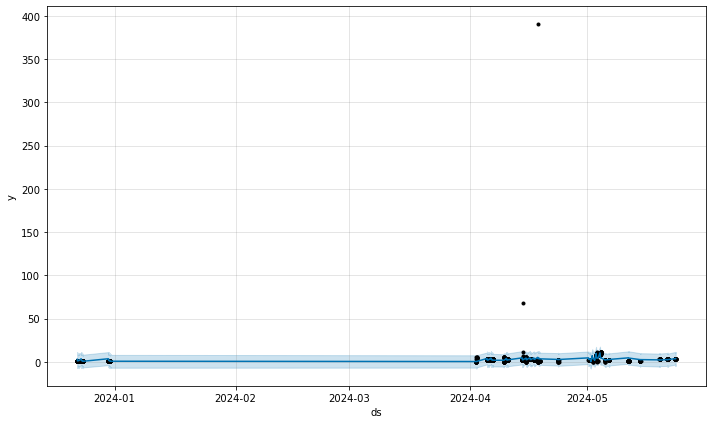

In [18]:
filtered_data['NPK_Ratio'] = filtered_data.apply(calculate_npk_ratio, axis=1)
print(filtered_data.columns)

# Anomaly Detection with Prophet
filtered_data_prophet = filtered_data[['Timestamp', 'NPK_Ratio']].rename(columns={'Timestamp': 'ds', 'NPK_Ratio': 'y'})
print(filtered_data_prophet.columns)
model = Prophet()
model.fit(filtered_data_prophet)
future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)
filtered_data['yhat'] = forecast['yhat']
filtered_data['yhat_lower'] = forecast['yhat_lower']
filtered_data['yhat_upper'] = forecast['yhat_upper']
filtered_data['Anomaly'] = (filtered_data['NPK_Ratio'] < filtered_data['yhat_lower']) | (filtered_data['NPK_Ratio'] > filtered_data['yhat_upper'])
anomalies = filtered_data[filtered_data['Anomaly']]

# Plot Prophet results with anomalies
fig = model.plot(forecast)
plt.scatter(anomalies['Timestamp'], anomalies['NPK_Ratio'], color='red')
plt.show()

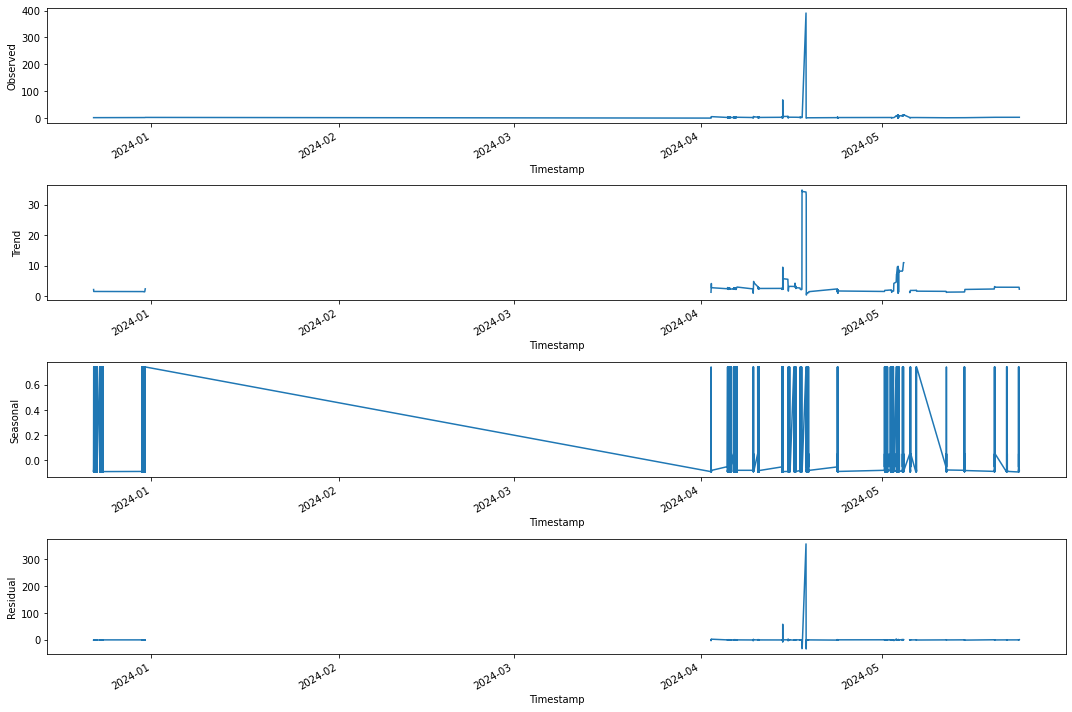

In [19]:
# Set 'Timestamp' as index
filtered_data.set_index('Timestamp', inplace=True)

# Handle missing values by interpolation
filtered_data['NPK_Ratio'] = filtered_data['NPK_Ratio'].interpolate(method='linear')

# Perform time series decomposition
result = seasonal_decompose(filtered_data['NPK_Ratio'], model='additive', period=12)

# Plot the results with increased width
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
result.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

In [20]:
filtered_data.head()

,Number of Worms (non-counted),Phosphorous01,Phosphorous02,Nitrogen01,Nitrogen02,Potassium01,Potassium02,Light Intensity,Temp01,Hum01,Heat01,SoilM01,SoilM02,Location,Hour,Minute,NPK_Ratio,yhat,yhat_lower,yhat_upper,Anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-02 15:30:00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,43,28.9,76.0,51.0,0.0,NaN,SengKang,15.0,30.0,0.0,3.036267,-4.166587,10.424296,False
2024-04-02 15:40:00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,43,28.9,77.0,52.0,0.0,NaN,SengKang,15.0,40.0,0.0,2.999896,-3.973114,10.373259,False
2024-04-02 15:50:00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,43,28.7,76.0,52.0,0.0,NaN,SengKang,15.0,50.0,0.0,2.963865,-4.468909,10.296378,False
2024-04-02 16:00:00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,44,28.9,77.0,52.0,0.0,NaN,SengKang,16.0,0.0,0.0,2.928179,-4.224714,10.653952,False
2024-04-02 16:10:00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,45,28.7,77.0,52.0,0.0,NaN,SengKang,16.0,10.0,0.0,2.892841,-4.793928,10.085576,False


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Regression with Random Forest
features = filtered_data[['Phosphorous01', 'Nitrogen01', 'Potassium01', 'Temp01', 'Hum01', 'Heat01', 'SoilM01', 'Hour', 'Minute']]
target = filtered_data['NPK_Ratio']
features.fillna(features.mean(), inplace=True)
target.fillna(target.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print()
print(f"Random Forest Regressor: MSE = {mse:.2f}, R2 = {r2:.2f}")

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print("\nDecision Tree Regressor:")
print(f"MSE = {mse_dt:.2f}, R2 = {r2_dt:.2f}")

# Other Models
# Models to test
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'XGBoost': XGBoost(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Test each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

# Print results
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.2f}, R2 = {metrics['R2']:.2f}")

C:\Users\Hannah\AppData\Local\Temp\ipykernel_29460\22558357.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)



Random Forest Regressor: MSE = 0.47, R2 = 0.67

Decision Tree Regressor:
MSE = 0.06, R2 = 0.96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 4661, number of used features: 9
[LightGBM] [Info] Start training from score 2.402602
Random Forest: MSE = 0.47, R2 = 0.67
Decision Tree: MSE = 0.06, R2 = 0.96
Ridge: MSE = 0.96, R2 = 0.34
Lasso: MSE = 1.45, R2 = -0.00
ElasticNet: MSE = 1.17, R2 = 0.20
XGBoost: MSE = 0.04, R2 = 0.97
AdaBoost: MSE = 0.45, R2 = 0.69
LightGBM: MSE = 1.40, R2 = 0.04
K-Nearest Neighbors: MSE = 0.06, R2 = 0.96


#### Pickling

In [22]:
import pickle
with open('random_forest_regressor.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [23]:
import pickle
with open('dt_regressor.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [24]:
import joblib
import numpy
import PIL
import h5py
import sklearn
import tensorflow
import keras
import streamlit

print("joblib version:", joblib.__version__)
print("numpy version:", numpy.__version__)
print("Pillow version:", PIL.__version__)
print("h5py version:", h5py.__version__)
print("scikit-learn version:", sklearn.__version__)
print("tensorflow version:", tensorflow.__version__)
print("keras version:", keras.__version__)
print("streamlit version:", streamlit.__version__)

joblib version: 1.3.2
numpy version: 1.26.4
Pillow version: 9.0.1
h5py version: 3.11.0
scikit-learn version: 1.2.2
tensorflow version: 2.16.1
keras version: 3.3.3
streamlit version: 1.31.0
